<a href="https://colab.research.google.com/github/matteo-ticli/CNN_LSTM-stock-prices-prediction/blob/main/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from keras.utils import to_categorical, plot_model
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv3D, MaxPooling3D, MaxPool3D, GlobalAveragePooling3D, Concatenate, Input
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K

In [4]:
tensor = np.load('/content/drive/MyDrive/FinalProject/data/tensor_1000_2000.npy')
labels = np.load('/content/drive/MyDrive/FinalProject/data/labels_1000_2000.npy')

In [19]:
x_train, x_test, y_train, y_test = train_test_split(tensor, labels, train_size=0.8, random_state = 42)

x_train, x_test = np.reshape(x_train, x_train.shape + (1,)), np.reshape(x_test, x_test.shape + (1,))
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

In [22]:
input_shape = x_train.shape[1:]
batch_size = 32
epochs = 100
num_filters = 10

####Try to replicate the paper model with two parallel CNN, one merge layer, one CNN, one CNN a flattened layer, a fully connected layer and the output layer

In [28]:
## define Input
inp = Input(shape=input_shape)

## two parallel Conv3D 
conv_1 = Conv3D(filters=num_filters, 
                kernel_size=(10, 1, 1), 
                padding='SAME', 
                data_format='channels_last',
                activation = 'relu',
                input_shape = input_shape)(inp)

conv_2 = Conv3D(filters=num_filters, 
                kernel_size=(10, 3, 3), 
                padding='SAME', 
                data_format='channels_last',
                activation = 'relu',
                input_shape = input_shape)(inp)

## merge layer
merged = Concatenate(axis=1)([conv_1, conv_2])

## third Conv3D 
conv_3 = Conv3D(filters=num_filters, 
                kernel_size=(10, 3, 5), 
                padding='SAME', 
                data_format='channels_last',
                activation = 'relu',
                input_shape = input_shape)(merged)

## fourth Conv3D
conv_4 = Conv3D(filters=num_filters, 
                kernel_size=(10, 3, 1), 
                padding='SAME', 
                data_format='channels_last',
                activation = 'relu',
                input_shape = input_shape)(conv_3)

## flat the network in order to feed a simple ANN
flat = Flatten()(conv_4)

## Fully connected network
dense_1 = Dense(10, activation='softmax')(flat)
dense_2 = Dense(4, activation='softmax')(dense_1)

out = Dense(2, activation='softmax')(dense_2)

model = Model(inputs=inp, outputs=out)

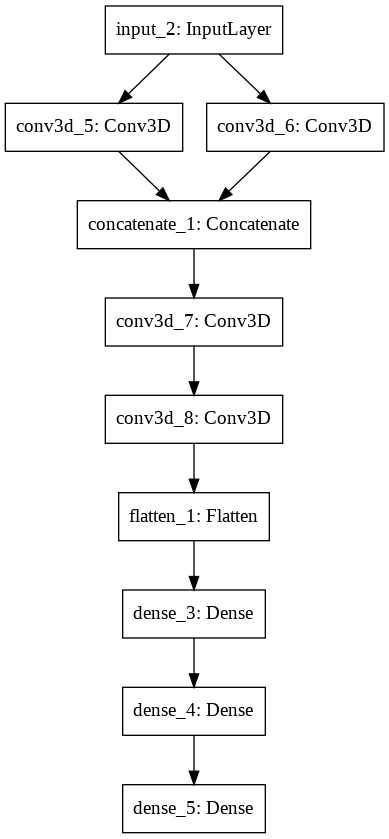

In [29]:
plot_model(model)

In [30]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 10, 10,  0                                            
__________________________________________________________________________________________________
conv3d_5 (Conv3D)               (None, 10, 10, 10, 1 110         input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_6 (Conv3D)               (None, 10, 10, 10, 1 910         input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 20, 10, 10, 1 0           conv3d_5[0][0]                   
                                                                 conv3d_6[0][0]             

In [35]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          verbose = 0,
          epochs=epochs);

In [36]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size = 32, verbose=0)
print(f'Accuracy: %{accuracy*100}')
print(f'Loss: %{loss*100}')

Accuracy: %51.99999809265137
Loss: %69.46015954017639
